<h1><b>Libraries</b></h1>

In [36]:
import os
import librosa
import math
import json 
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *

<h1><b>Data Preprocessing</b></h1>

In [2]:
# file path
dataset_path = r"./Music_Genre_Classification_Dataset/genres_original"
# mfcc file
json_path = r"./Music_Genre_Classification_Dataset/data.json"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

### MFCC Features

In [3]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048,
             hop_length=512, num_segments=5):
    # Data storage dictionary
    data = {
        "mapping": [],
        "mfcc": [],
        "labels": [],
    }
    samples_ps = int(SAMPLES_PER_TRACK/num_segments) # ps = per segment
    expected_vects_ps = math.ceil(samples_ps/hop_length)
    
    # loop through all the genres
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        # ensuring not at root
        if dirpath is not dataset_path:
            # save the semantic label
            dirpath_comp = dirpath.split("/")
            semantic_label = dirpath_comp[-1]
            data["mapping"].append(semantic_label)
            print(f"Processing: {semantic_label}")
            
            # process files for specific genre
            for f in filenames:
                if(f==str("jazz.00054.wav")):
                    continue
                else:
                    # load audio file
                    file_path = os.path.join(dirpath, f)
                    signal,sr = librosa.load(file_path,sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = samples_ps * s
                        finish_sample = start_sample + samples_ps

                        mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                                    sr = sr,
                                                    n_fft = n_fft,
                                                    n_mfcc = n_mfcc,
                                                    hop_length = hop_length)

                        mfcc = mfcc.T

                        # store mfcc if it has expected length 
                        if len(mfcc)==expected_vects_ps:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
                            print(f"{file_path}, segment: {s+1}")

    with open(json_path,"w") as f:
        json.dump(data,f,indent=4)

In [4]:
save_mfcc(dataset_path,json_path,num_segments=10)
clear_output()

### data visualization

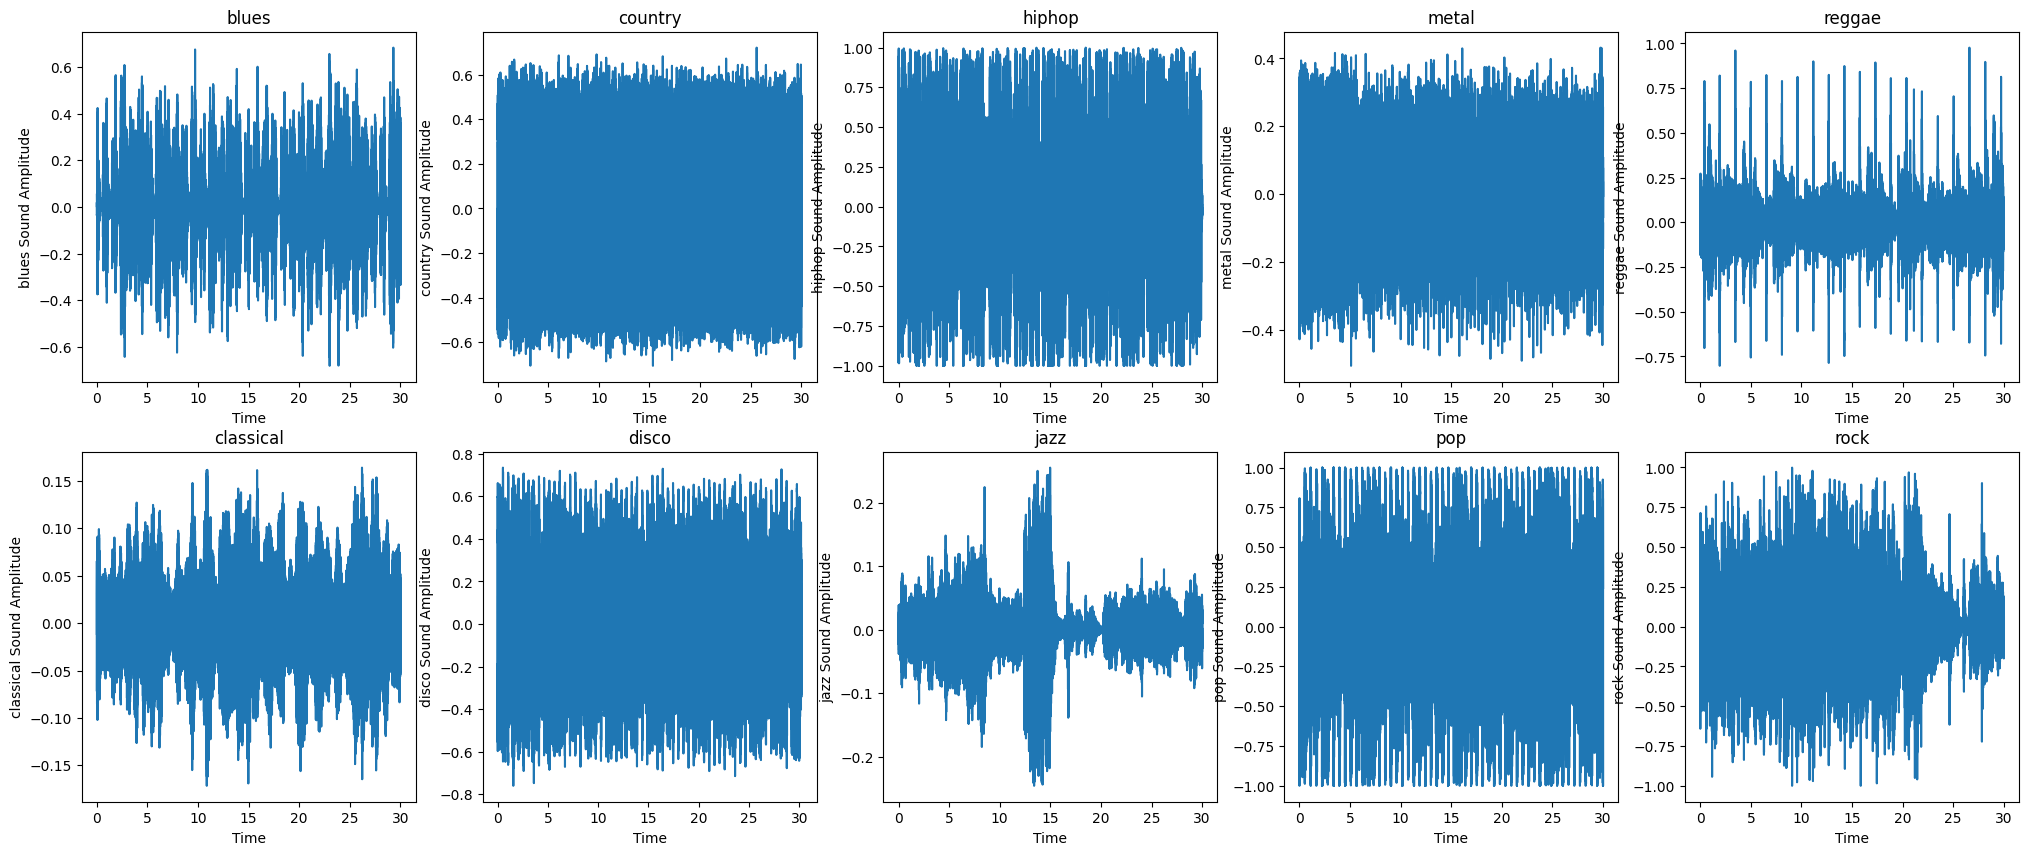

In [5]:
types = ['blues', 'country', 'hiphop', 'metal', 'reggae', 'classical', 'disco', 'jazz', 'pop', 'rock']

plt.figure(figsize=(25, 10))
for index,type in enumerate(types):
    filepath = r"./Music_Genre_Classification_Dataset/genres_original/"+type+"/"+type+".00001.wav"
    audio, sfreq = librosa.load(filepath)
    time = np.arange(0, len(audio))/sfreq
    plt.subplot(2,5,index+1)
    plt.plot(time,audio)
    plt.title(type)
    plt.xlabel("Time")
    plt.ylabel(type+" Sound Amplitude")
plt.show()

In [28]:
# load data
def load_data(dataset_path):
    with open(dataset_path,"r") as f:
        data = json.load(f)
    
    # Convert list to numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])    
    
    return inputs,targets

<h1><b>Model Compare</b></h1>

### Timer

In [21]:
import time
class Timer:
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

### Learning Curve Plot

In [32]:
def plot_learning_curve(clf, X, y, title='Learning Curve', cv=None,
                        shuffle=False, random_state=None,
                        train_sizes=None, n_jobs=1, scoring=None,
                        ax=None, figsize=None, title_fontsize="large",
                        text_fontsize="medium"):
    """Generates a plot of the train and test learning curves for a classifier.

    Returns:
    - ax: Matplotlib axes object containing the learning curve plot
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    if train_sizes is None:
        train_sizes = np.linspace(.1, 1.0, 5)

    # Set plot title and axis labels
    ax.set_title(title, fontsize=title_fontsize)
    ax.set_xlabel("Training examples", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)

    # Compute learning curves using cross-validation
    train_sizes, train_scores, test_scores = learning_curve(
        clf, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring=scoring, shuffle=shuffle, random_state=random_state)
    
    # Calculate means and standard deviations of training and cross-validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Customize plot appearance
    ax.grid(axis='y', color="#E2E8F0")
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="#E9BA98")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="#b3bfd1")
    ax.plot(train_sizes, train_scores_mean, marker="o", linestyle="-", color="#e69357",
            label="Training score", linewidth=1, markersize=3.6)
    ax.plot(train_sizes, test_scores_mean, marker="o", linestyle="-", color="#2E6A99",
            label="Cross-validation score", linewidth=1, markersize=3.6)
    ax.tick_params(labelsize=6)
    ax.legend(loc="best", fontsize=text_fontsize)

    return ax

In [29]:
# Reduce parameters from 3 dimensions to 2 dimensions
def load_model_data():
    inputs,targets = load_data(r"./Music_Genre_Classification_Dataset/data.json")
    input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3, random_state=42)
    X_train = np.reshape(input_train, (input_train.shape[0], -1))
    X_test = np.reshape(input_test, (input_test.shape[0], -1))
    y_train, y_test = target_train, target_test
    return X_train, X_test, y_train, y_test

### Decision Tree

In [50]:
import numpy as np
import time
from matplotlib import pyplot as plt
from sklearn import preprocessing, tree, metrics, impute
from sklearn.metrics import accuracy_score, precision_score

def decision_tree_feature_selection(X_train, y_train, X_test, y_test, criterion="gini",max_depth = [3,5,7,9,12], min_sample = [3, 5,10,15]):

    # Initialize data
    X_train = X_train
    y_train = y_train
    test_labels = y_test

    # Set Parameter for selection
    max_depth = [3,5,7,9,12]
    accuracy_list = []
    run_time = []
    for d in max_depth:
        # Set up Models from skleanr
        clf = tree.DecisionTreeClassifier(
            criterion="gini",
            splitter="random",
            max_depth= d
        )

        start = time.time()

        clf.fit(X_train , y_train)
        predicted_labels = clf.predict(X_test)
        accuracy= float(accuracy_score(test_labels, predicted_labels))
        accuracy_list.append(accuracy)

        end = time.time()
        run_time.append(end - start)

    # Initialise the subplot function using number of rows and columns
    fig, axis = plt.subplots(2, 2)
    fig.set_size_inches(16,9)
    fig.suptitle('Decision Tree Pruning Coefficient Comparion', fontsize=16)

    axis[0, 0].plot(max_depth,run_time)
    axis[0, 0].set_xlabel('Max Depth', fontsize=12)
    axis[0, 0].xaxis.set_label_coords(.9, -.1)
    axis[0, 0].set_ylabel('Run time', fontsize=12)
    axis[0, 0].set_title('Depth/ Run time')
    axis[0, 0].grid(axis='y', color="#E2E8F0")


    axis[0, 1].plot(max_depth, accuracy_list)
    axis[0, 1].set_xlabel('Max Depth', fontsize=12)
    axis[0, 1].xaxis.set_label_coords(.9, -.1)
    axis[0, 1].set_ylabel('Accuracy', fontsize=12)
    axis[0, 1].set_title('Depth/ Accuracy')
    # axis[0, 1].axvline(x=9, color='r', linestyle='dashed', linewidth=3, label='Tree Depth = 9', alpha=0.45)
    axis[0, 1].legend()
    axis[0, 1].grid(axis='y', color="#E2E8F0")

    min_sample = [3, 5,10,15]
    accuracy_list = []
    run_time = []
    for s in min_sample:
        clf = tree.DecisionTreeClassifier(
            criterion="gini",
            splitter="random",
            min_samples_leaf= s
        )

        start = time.time()

        clf.fit(X_train , y_train)
        predicted_labels = clf.predict(X_test)
        accuracy= float(accuracy_score(test_labels, predicted_labels))
        accuracy_list.append(accuracy)

        end = time.time()
        run_time.append(end - start)

    axis[1, 0].plot(min_sample, run_time)
    axis[1, 0].grid(axis='y', color="#E2E8F0")
    axis[1, 0].xaxis.set_label_coords(.9, -.1)
    axis[1, 0].set_ylabel('Run time', fontsize=12)
    axis[1, 0].set_xlabel('Min Leaf Size', fontsize=12)
    axis[1, 0].set_title('Leaf Size/ Run time')

    axis[1, 1].plot(min_sample, accuracy_list, linewidth=2)
    axis[1, 1].xaxis.set_label_coords(.9, -.1)
    axis[1, 1].set_xlabel('Min Leaf Size', fontsize=12)
    axis[1, 1].set_ylabel('accuracy', fontsize=12)
    axis[1, 1].set_title('Leaf Size/ Accuracy')
    # axis[1, 1].axvline(x=5, color='r', linestyle='dashed', linewidth=3, label='Leaf Size = 5', alpha=0.45)
    plt.grid(axis='y', color="#E2E8F0")
    plt.legend()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


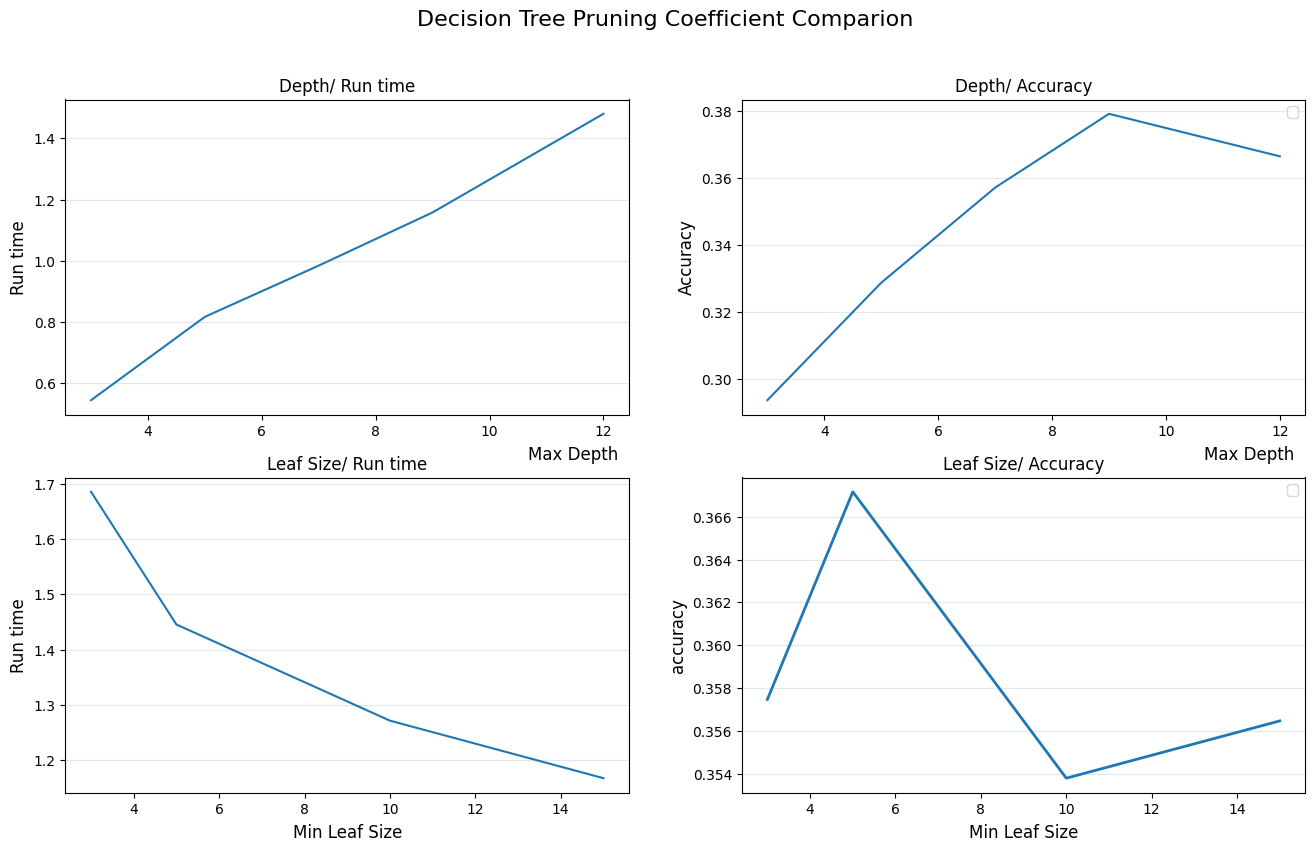

In [51]:
X_train, X_test, y_train, y_test = load_model_data()
decision_tree_feature_selection(X_train, y_train, X_test, y_test, criterion="gini",max_depth = [3,5,7,9,12,15,20,25], min_sample = [3,5,10,15,20,25])

#### Decision Tree Learning Curve

In [18]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, tree, metrics, impute
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score

def decision_tree(dataset, X_train, X_test, y_train, y_test):
    # initialize data
    data_in = np.concatenate((X_train, X_test))
    data_out = np.concatenate((y_train, y_test))

    # Set Classification Models
    clf = tree.DecisionTreeClassifier(
        criterion="gini",
        splitter="random"
    )

    # Count time consumed and fit model
    with Timer() as t:
      clf.fit(X_train, y_train)

    time_to_fit = t.interval * 1000 # in MS
    predicted = clf.predict(X_train)
    train_f1_score = metrics.f1_score(y_train, predicted, average='micro')

    # Predict model
    with Timer() as t:
      predicted = clf.predict(X_test)
    test_f1_score = metrics.f1_score(y_test, predicted, average='micro')

    test_prediction_runtime = t.interval * 1000 # in MS

    # Metric for critique models
    accuracy = accuracy_score(y_test, predicted) * 100
    precision = precision_score(y_test, predicted, average="weighted") * 100
    recall = recall_score(y_test, predicted, average='micro') * 100

    print("Descision Tree Results on " + dataset +" (no pruning)")
    print("Tree depth", clf.tree_.max_depth)
    print("Tree Feature", clf.tree_.node_count)
    print("training f1 score:", train_f1_score)
    print("test f1 score:", test_f1_score)
    print("time to fit:", time_to_fit)
    print("test prediction runtime:", test_prediction_runtime)
    print("test Recall", recall)
    print("test accuracy", accuracy)
    print("test precision", precision)
    print()

    plot_learning_curve(
        clf, data_in, data_out, title="Learning Curve: Decision Trees on " + dataset +" (no pruning)", cv=5, title_fontsize= 10,
                        text_fontsize= 8)

    clf = tree.DecisionTreeClassifier(
        criterion="gini",
        splitter="random",
        min_samples_leaf=5,  # minimum of 10 samples at leaf nodes
        max_depth=9
    )

    with Timer() as t:
      clf.fit(X_train, y_train)

    time_to_fit = t.interval * 1000

    predicted = clf.predict(X_train)
    train_f1_score = metrics.f1_score(y_train, predicted, average='micro')

    with Timer() as t:
      predicted = clf.predict(X_test)
    test_f1_score = metrics.f1_score(y_test, predicted, average='micro')

    test_prediction_runtime = t.interval * 1000

    y_test = y_test

    accuracy = accuracy_score(y_test, predicted) * 100
    precision = precision_score(y_test, predicted, average="weighted") * 100
    recall = recall_score(y_test, predicted, average='micro') * 100

    print("Descision Tree Results on " + dataset +" (pruned)")
    print("Tree depth", clf.tree_.max_depth)
    print("Tree Feature", clf.tree_.node_count)
    print("training f1 score:", train_f1_score)
    print("test f1 score:", test_f1_score)
    print("time to fit:", time_to_fit)
    print("test prediction runtime:", test_prediction_runtime)
    print("test Recall", recall)
    print("test accuracy", accuracy)
    print("test precision", precision)
    print()

    plot_learning_curve(
        clf, data_in, data_out, title="Learning Curve: Decision Trees on " + dataset +" (pruned)", cv=5, title_fontsize= 10, text_fontsize= 8)

Descision Tree Results on Genre (no pruning)
Tree depth 22
Tree Feature 3993
training f1 score: 0.9989985693848354
test f1 score: 0.3471295060080107
time to fit: 2062.359094619751
test prediction runtime: 23.205995559692383
test Recall 34.712950600801065
test accuracy 34.712950600801065
test precision 34.74823456288228

Descision Tree Results on Genre (pruned)
Tree depth 9
Tree Feature 675
training f1 score: 0.5599427753934192
test f1 score: 0.362483311081442
time to fit: 1223.4411239624023
test prediction runtime: 15.125036239624023
test Recall 36.24833110814419
test accuracy 36.24833110814419
test precision 35.08245839616077



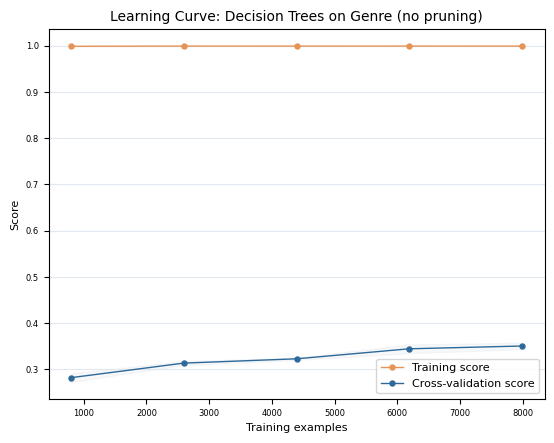

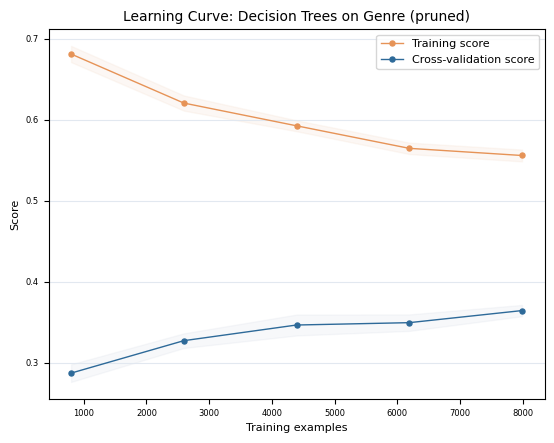

In [33]:
X_train, X_test, y_train, y_test = load_model_data()
decision_tree('Genre', X_train, X_test, y_train, y_test)

### KNN

In [48]:
import numpy as np
from matplotlib import pyplot as plt
import time
import warnings
from sklearn import preprocessing, metrics, impute
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

def knn(dataset, k_value, X_train, X_test, y_train, y_test):

    x = list()
    y_train_res = list()
    y_test_res = list()
    y_cross_res = list()

    data_in = np.concatenate((X_train, X_test))
    data_out = np.concatenate((y_train, y_test))

    # chart different k-values vs. f1 score first
    for i in range(60):
        _k = i + 1
        clf = KNeighborsClassifier(n_neighbors=_k)
        clf.fit(X_train, y_train)
        predicted = clf.predict(X_train)
        train_f1_score = metrics.f1_score(y_train, predicted, average='micro')
        predicted = clf.predict(X_test)
        test_f1_score = metrics.f1_score(y_test, predicted, average='micro')

        cross_val = cross_val_score(clf, data_in, data_out, cv=5)

        x.append(_k)
        y_train_res.append(train_f1_score)
        y_test_res.append(test_f1_score)
        y_cross_res.append(np.mean(cross_val))

    plt.figure()
    plt.title('Scores for various k on ' + dataset)
    plt.xlabel('k value')
    plt.ylabel('Score')
    plt.plot(x, y_train_res, label='Training F1 score')
    plt.plot(x, y_test_res, label='Testing F1 score')
    plt.plot(x, y_cross_res, label='Cross-validation score')
    plt.grid(axis='y', color="#E2E8F0")
    plt.legend()

    clf = KNeighborsClassifier(n_neighbors=k_value, weights='distance')

    with Timer() as t:
      clf.fit(X_train, y_train)

    time_to_fit = t.interval * 1000 # in ms

    predicted = clf.predict(X_train)
    train_f1_score = metrics.f1_score(y_train, predicted, average='micro')

    with Timer() as t:
      predicted = clf.predict(X_test)
    test_f1_score = metrics.f1_score(y_test, predicted, average='micro')
    
    test_prediction_runtime = t.interval * 1000 # in ms

    recall = recall_score(y_test, predicted, average='micro') * 100
    accuracy = accuracy_score(y_test, predicted) * 100
    precision = precision_score(y_test, predicted, average="weighted") * 100

    print(dataset + " dataset (KNN k={})".format(k_value))
    print("training f1 score:", train_f1_score)
    print("test f1 score:", test_f1_score)
    print("time to fit:", time_to_fit)
    print("test prediction runtime:", test_prediction_runtime)
    print("test Recall", recall)
    print("test accuracy", accuracy)
    print("test precision", precision)
    print()


    plot_learning_curve(
      clf, data_in, data_out, title="Learning Curve: kNN (Genre.dataset, k={})".format(k_value), cv=5)

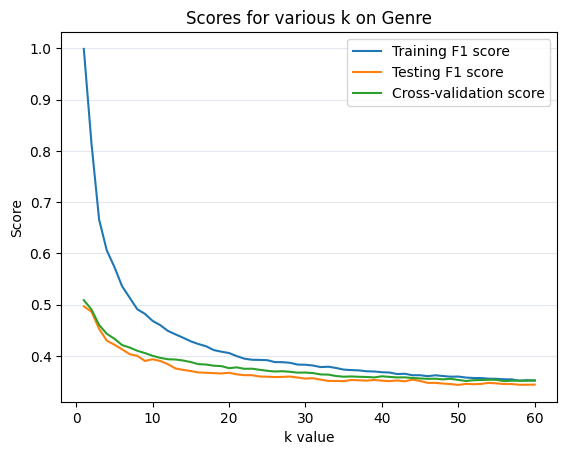

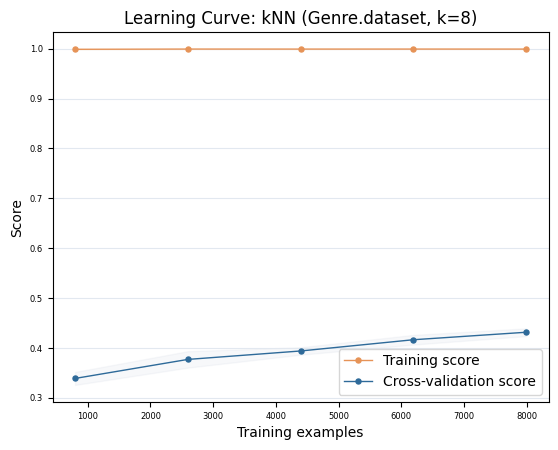

In [49]:
X_train, X_test, y_train, y_test = load_model_data()
knn('Genre', 8, X_train, X_test, y_train, y_test)
clear_output()

### Boosting

In [46]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, tree, metrics, impute
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, zero_one_loss, recall_score
from sklearn.tree import DecisionTreeClassifier

# Clean warnings
import warnings
warnings.filterwarnings("ignore")

def save_error_graph(X_train,X_test, y_train, y_test, figname, dt_params, max_n_estimators=1000, learning_rate=1., y_max=.4, title=None):

    dt_stump = DecisionTreeClassifier(max_depth=1, min_samples_leaf=1)
    dt_stump.fit(X_train, y_train)
    dt_stump_err = 1.0 - dt_stump.score(X_test, y_test)

    dt = DecisionTreeClassifier(**dt_params)
    dt.fit(X_train, y_train)
    dt_err = 1.0 - dt.score(X_test, y_test)

    ada_discrete = AdaBoostClassifier(
        base_estimator=dt_stump,
        learning_rate=learning_rate,
        n_estimators=max_n_estimators,
        algorithm="SAMME")
    ada_discrete.fit(X_train, y_train)

    ada_real = AdaBoostClassifier(
        base_estimator=dt_stump,
        learning_rate=learning_rate,
        n_estimators=max_n_estimators,
        algorithm="SAMME.R")
    ada_real.fit(X_train, y_train)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ada_discrete_err = np.zeros((max_n_estimators,))
    for i, y_pred in enumerate(ada_discrete.staged_predict(X_test)):
        ada_discrete_err[i] = zero_one_loss(y_pred, y_test)

    ada_discrete_err_train = np.zeros((max_n_estimators,))
    for i, y_pred in enumerate(ada_discrete.staged_predict(X_train)):
        ada_discrete_err_train[i] = zero_one_loss(y_pred, y_train)

    ada_real_err = np.zeros((max_n_estimators,))
    for i, y_pred in enumerate(ada_real.staged_predict(X_test)):
        ada_real_err[i] = zero_one_loss(y_pred, y_test)

    ada_real_err_train = np.zeros((max_n_estimators,))
    for i, y_pred in enumerate(ada_real.staged_predict(X_train)):
        ada_real_err_train[i] = zero_one_loss(y_pred, y_train)

    ax.plot(np.arange(max_n_estimators) + 1, ada_discrete_err,
            label='Discrete AdaBoost Test Error') # ,color='red'
    ax.plot(np.arange(max_n_estimators) + 1, ada_discrete_err_train,
            label='Discrete AdaBoost Train Error') # , color='blue'
    ax.plot(np.arange(max_n_estimators) + 1, ada_real_err,
            label='Real AdaBoost Test Error')  # , color='orange'
    ax.plot(np.arange(max_n_estimators) + 1, ada_real_err_train,
            label='Real AdaBoost Train Error') #, color='green'

    ax.plot([1, max_n_estimators], [dt_stump_err] * 2, 'k-',
            label='Decision Stump Error', color = "#c44b4b", linewidth=1)
    ax.plot([1, max_n_estimators], [dt_err] * 2, 'k--',
            label='Decision Tree Error', color = "#c44b4b", dashes=(16, 7), linewidth=1.2)

    # ax.set_ylim((0.0, y_max))
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('error rate')

    leg = ax.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.7)

    if title:
        plt.title(title)

def boosting(dataset, n_estimators, learning_rate , X_train, X_test, y_train, y_test):

    clf = AdaBoostClassifier(tree.DecisionTreeClassifier(
        criterion="gini",
        splitter="random",
        min_samples_leaf=5,  # minimum of 5 samples at leaf nodes
        max_depth=9
    ), n_estimators=n_estimators, algorithm="SAMME", learning_rate=learning_rate)

    with Timer() as t:
      clf.fit(X_train, y_train)

    time_to_fit = t.interval

    predicted = clf.predict(X_train)
    train_f1_score = metrics.f1_score(y_train, predicted, average='micro')

    with Timer() as t:
      predicted = clf.predict(X_test)
    test_f1_score = metrics.f1_score(y_test, predicted, average='micro')

    test_prediction_runtime = t.interval 

    data_in = np.concatenate((X_train, X_test))
    data_out = np.concatenate((y_train, y_test))

    accuracy = accuracy_score(y_test, predicted) * 100
    precision = precision_score(y_test, predicted, average="weighted") * 100
    recall = recall_score(y_test, predicted, average='micro') * 100

    print(dataset + " dataset (n_estimators={})".format(n_estimators))
    print("training f1 score:", train_f1_score)
    print("test f1 score:", test_f1_score)
    print("time to fit:", time_to_fit)
    print("test prediction runtime:", test_prediction_runtime)
    print("test Recall", recall)
    print("test accuracy", accuracy)
    print("test precision", precision)
    print()
    plot_learning_curve(
        clf, data_in, data_out, cv=5,
        title="Learning Curve: Boosting (Genre.dataset, n_est={}, l_rate={})".format(
            n_estimators, learning_rate
        ),
    )

    for l_rate in [0.1, 0.5, 1.0]:
      #l_rate = i
      save_error_graph(X_train,X_test, y_train, y_test, 'genre-error-lrate-{}'.format(l_rate), {
                          "criterion": "gini",
                          "splitter": "random",
                          "min_samples_leaf": 5,
                          "max_depth": 9
                      },
                      max_n_estimators=250, learning_rate=l_rate, y_max=.4,
                      title="Genre.dataset, boosting (learning_rate={})".format(l_rate))

Genre dataset (n_estimators=1)
training f1 score: 0.5583690987124463
test f1 score: 0.34746328437917223
time to fit: 1.4626541137695312
test prediction runtime: 0.038743019104003906
test Recall 34.74632843791722
test accuracy 34.74632843791722
test precision 34.01056244049424



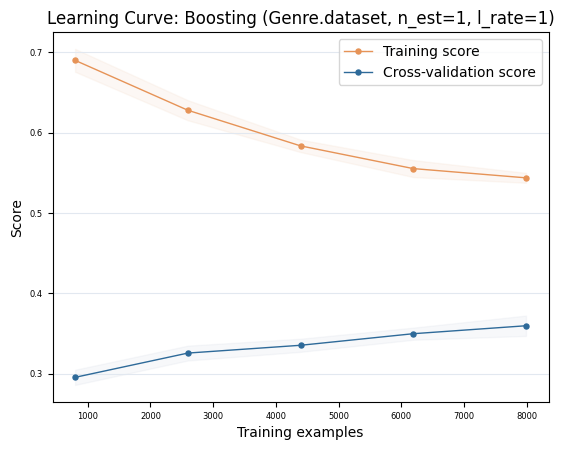

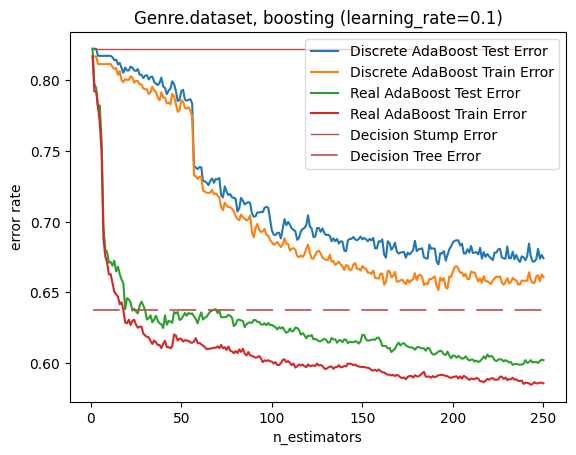

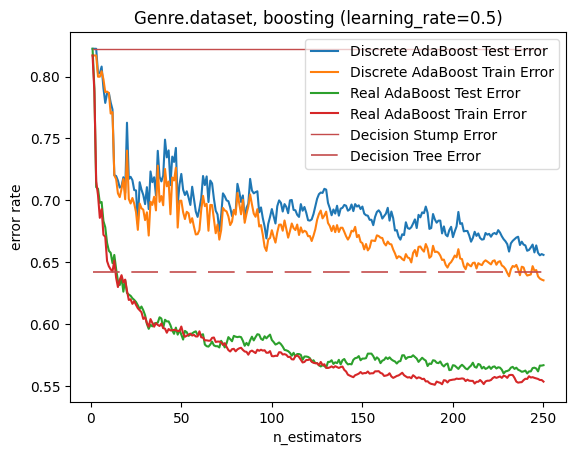

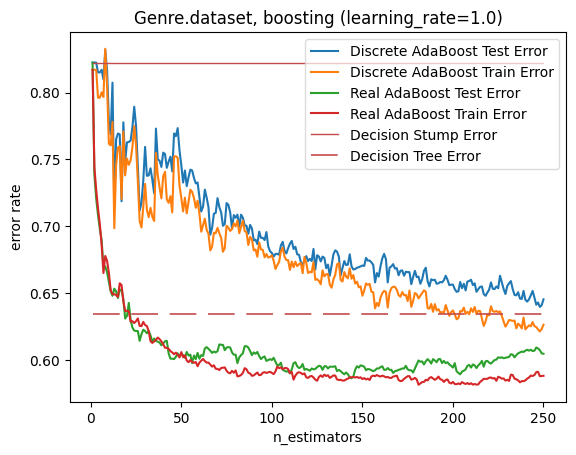

In [47]:
X_train, X_test, y_train, y_test = load_model_data()
boosting('Genre', 1, 1 , X_train, X_test, y_train, y_test)

### SVM

In [44]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import preprocessing, svm, metrics, impute
from sklearn.metrics import accuracy_score, precision_score

def svm_on(dataset, kernel, X_train,X_test, y_train, y_test):

    kernel= kernel
    clf = svm.SVC(
        kernel=kernel
    )

    with Timer() as t:
      clf.fit(X_train, y_train)

    time_to_fit = t.interval 

    predicted = clf.predict(X_train)
    train_f1_score = metrics.f1_score(y_train, predicted, average='micro')

    with Timer() as t:
      predicted = clf.predict(X_test)
    test_f1_score = metrics.f1_score(y_test, predicted, average='micro')

    test_prediction_runtime = t.interval 

    data_in = np.concatenate((X_train, X_test))
    data_out = np.concatenate((y_train, y_test))

    t_out = y_test

    accuracy = accuracy_score(t_out, predicted) * 100
    precision = precision_score(t_out, predicted, average="weighted") * 100

    print("{} (SVM kernel={})".format(dataset, kernel))
    print("training f1 score:", train_f1_score)
    print("test f1 score:", test_f1_score)
    print("time to fit:", time_to_fit)
    print("test prediction runtime:", test_prediction_runtime)
    print("test accuracy", accuracy)
    print("test precision", precision)
    print()

    plot_learning_curve(
        clf, data_in, data_out, title="Learning Curve: SVM (genre.dataset, kernel={})".format(kernel), cv=5)

Genre (SVM kernel=linear)
training f1 score: 0.9989985693848354
test f1 score: 0.4395861148197597
time to fit: 59.9177188873291
test prediction runtime: 16.165451049804688
test accuracy 43.958611481975964
test precision 42.64979859240219

Genre (SVM kernel=rbf)
training f1 score: 0.6080114449213162
test f1 score: 0.5560747663551402
time to fit: 33.25289583206177
test prediction runtime: 26.508023738861084
test accuracy 55.60747663551402
test precision 54.271371199870046

Genre (SVM kernel=poly)
training f1 score: 0.5274678111587983
test f1 score: 0.4863150867823765
time to fit: 38.35364127159119
test prediction runtime: 15.39697813987732
test accuracy 48.63150867823765
test precision 50.50929246350052



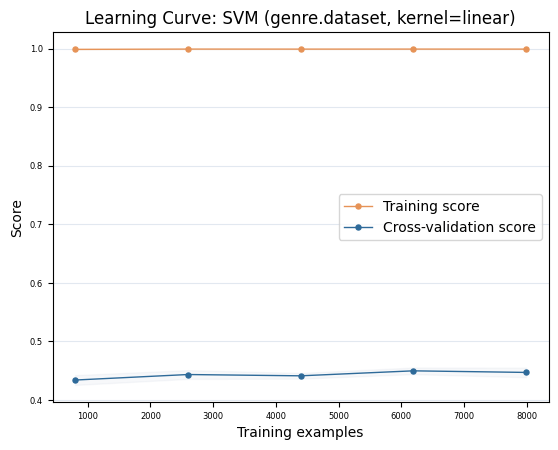

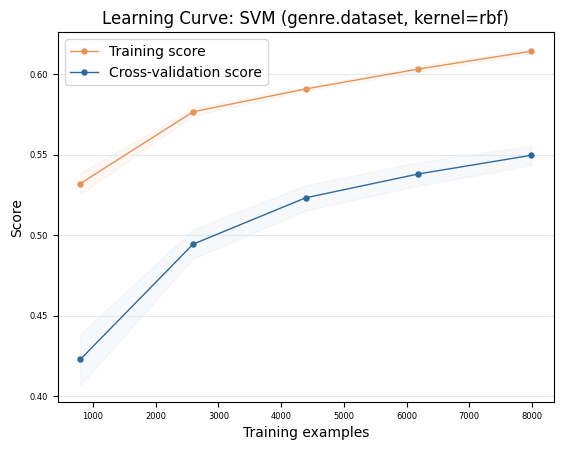

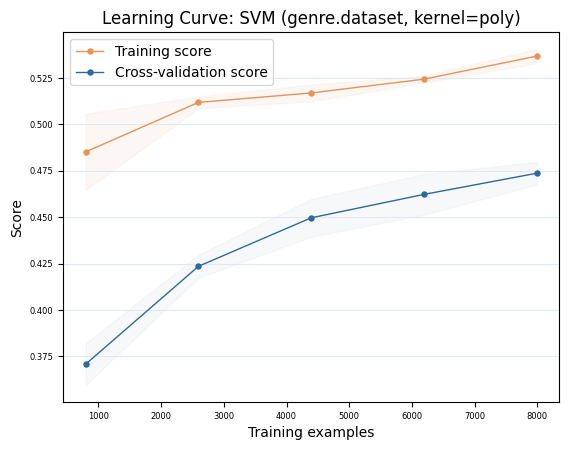

In [45]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

X_train, X_test, y_train, y_test = load_model_data()
for kernel in ["linear", "rbf", "poly"]:
  svm_on("Genre", kernel, X_train, X_test, y_train, y_test)

### MLP

In [52]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics, impute, neural_network, preprocessing
from sklearn.metrics import accuracy_score, precision_score

def neural_netx(dataset, solver, X_train,X_test, y_train, y_test):

    clf = neural_network.MLPClassifier(
        solver=solver, warm_start=True, max_iter=1000
    )

    with Timer() as t:
      clf.fit(X_train, y_train)

    time_to_fit = t.interval

    predicted = clf.predict(X_train)
    train_f1_score = metrics.f1_score(y_train, predicted, average='micro')

    with Timer() as t:
      predicted = clf.predict(X_test)
    test_f1_score = metrics.f1_score(y_test, predicted, average='micro')

    test_prediction_runtime = t.interval 

    data_in = np.concatenate((X_train, X_test))
    data_out = np.concatenate((y_train, y_test))

    accuracy = accuracy_score(y_test, predicted) * 100
    precision = precision_score(y_test, predicted, average="weighted") * 100

    print("{} (solver={})".format(dataset, solver))
    print("training f1 score:", train_f1_score)
    print("test f1 score:", test_f1_score)
    print("time to fit:", time_to_fit)
    print("test prediction runtime:", test_prediction_runtime)
    print("test accuracy", accuracy)
    print("test precision", precision)
    print()

    plot_learning_curve(
        clf, data_in, data_out, title="Learning Curve: Neural Net ({}, solver={})".format(dataset, solver), cv=5)

Genre (solver=adam)
training f1 score: 0.7117310443490701
test f1 score: 0.46261682242990654
time to fit: 29.47835373878479
test prediction runtime: 0.019803762435913086
test accuracy 46.26168224299065
test precision 47.393590002841314



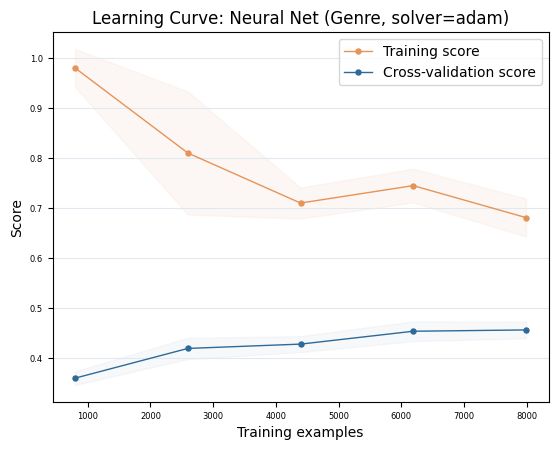

In [53]:
X_train, X_test, y_train, y_test = load_model_data()
neural_netx('Genre', 'adam', X_train,X_test, y_train, y_test)

<h3>ANN</h3>

In [54]:
# load data
inputs,targets = load_data(r"./Music_Genre_Classification_Dataset/data.json")
input_train, input_test, target_train, target_test = train_test_split(inputs, targets, test_size=0.3, random_state=42)
print(input_train.shape, target_train.shape)

(6990, 130, 13) (6990,)


In [55]:
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 1014218 (3.87 MB)
Trainable params: 1014218 (3.87 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
adam = optimizers.legacy.Adam(lr=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)
clear_output()

In [57]:
def plot_history(hist):
    plt.figure(figsize=(8, 10))
    plt.subplot(2,1,1)
    plt.plot(hist.history["accuracy"], label="train accuracy")
    plt.plot(hist.history["val_accuracy"], label="test accuracy")
    plt.title("Accuracy eval")
    plt.legend(loc="lower right")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    
    # Error subplot
    plt.subplot(2,1,2)
    plt.plot(hist.history["loss"], label="train error")
    plt.plot(hist.history["val_loss"], label="test error")
    plt.title("Error eval")
    plt.legend(loc="upper right")
    plt.ylabel("Error")
    plt.xlabel("Epoch")
    plt.show()

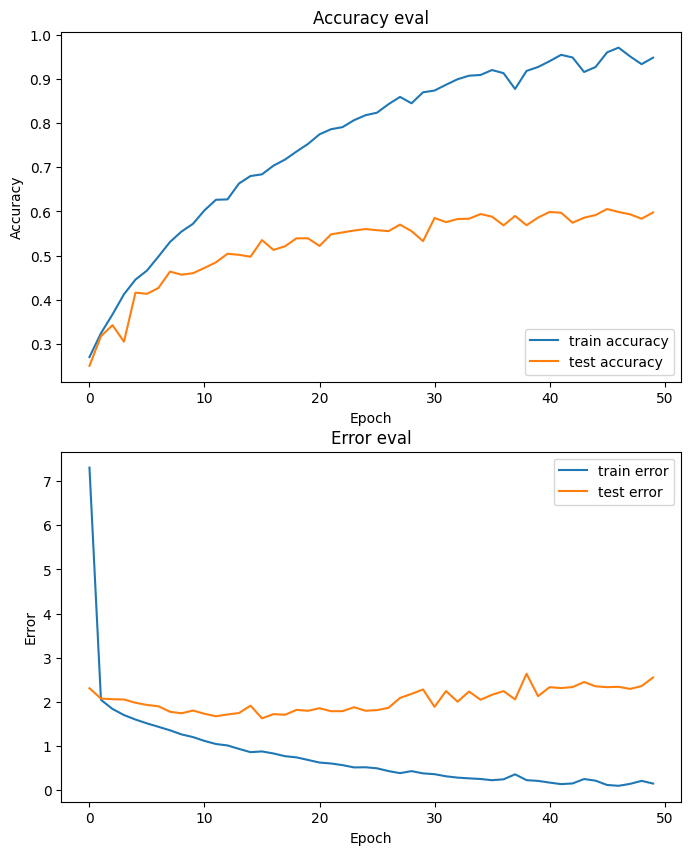

In [58]:
plot_history(hist)

In [59]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 2ms/step - loss: 2.5545 - accuracy: 0.5978
Test accuracy: 0.5977970361709595


#### Overfitting
This part deals with the overfitting of the previous model. We can deal with it by majorly doing the following process.

**Making architecture less complicated**    
**Using augmented data**    
**Early stopping of training**    
**Adding dropout layers**    
**Regularization / Standardization**    
I have added the dropout layers and kernel_regularizers as compared to previous naive model giving the dropout probability as 30% Kernel_regularizers is one of the 3 type of regularizer used to impose penalties. 

#### kernel_regularizers L2

In [60]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l2(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l2(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 1690)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)               

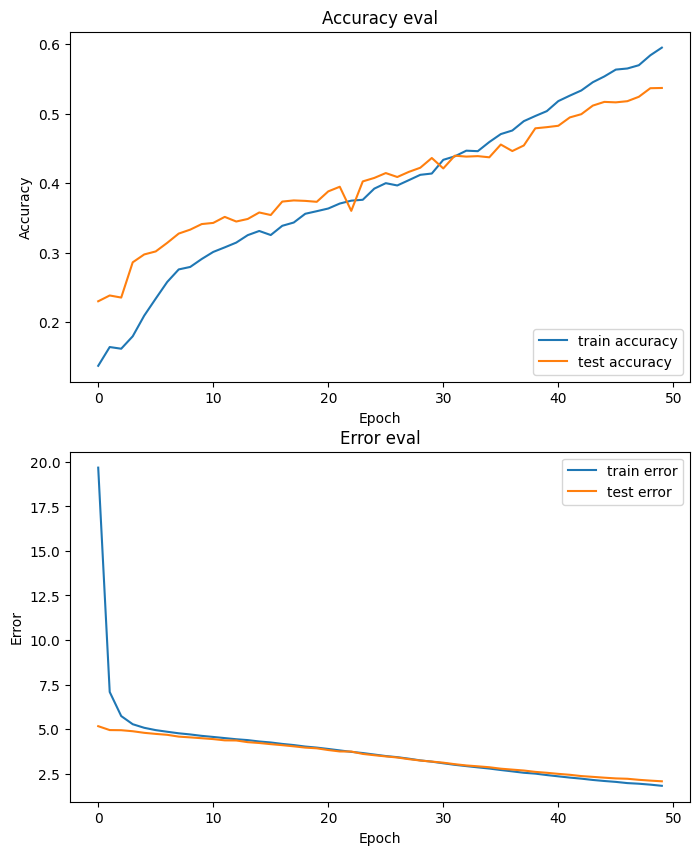

In [61]:
adam = optimizers.legacy.Adam(lr=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()

plot_history(hist)

In [62]:
test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

94/94 [==============================] - 0s 3ms/step - loss: 2.0679 - accuracy: 0.5370
Test accuracy: 0.537049412727356


#### kernel_regularizers L1

In [63]:
# Overfitting
model = Sequential()

model.add(Flatten(input_shape=(inputs.shape[1],inputs.shape[2])))
model.add(Dense(512, activation='relu', kernel_regularizer = keras.regularizers.l1(0.001)))
model.add(Dropout(0.3))
model.add(Dense(256, activation='relu', kernel_regularizer = keras.regularizers.l1(0.003)))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer = keras.regularizers.l1(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 1690)              0         
                                                                 
 dense_9 (Dense)             (None, 512)               865792    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               131328    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)               

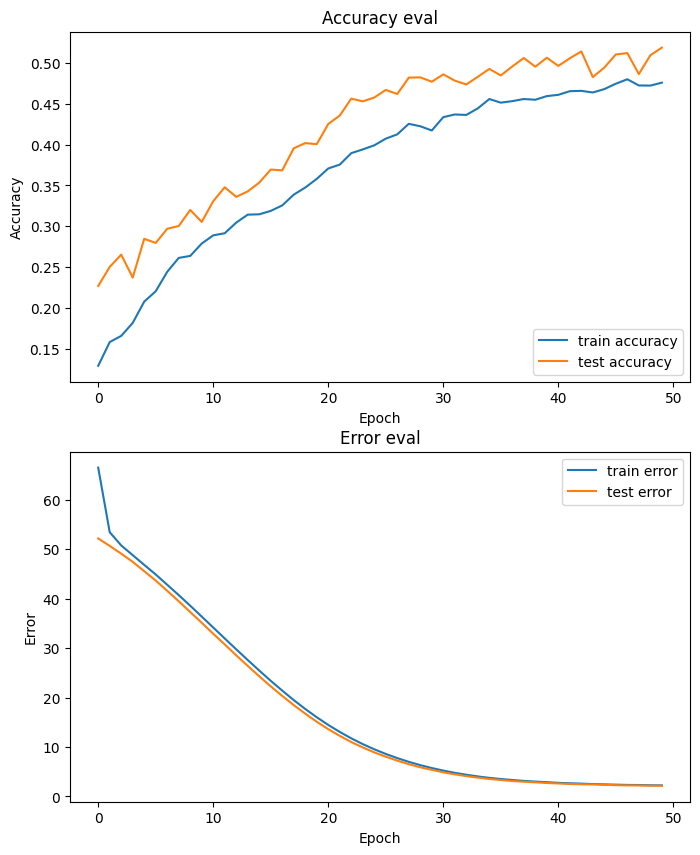

94/94 [==============================] - 0s 3ms/step - loss: 2.1560 - accuracy: 0.5187
Test accuracy: 0.5186915993690491


In [64]:
adam = optimizers.legacy.Adam(lr=1e-4)
model.compile(optimizer=adam,
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

hist = model.fit(input_train, target_train,
                 validation_data = (input_test,target_test),
                 epochs = 50,
                 batch_size = 32)

clear_output()

plot_history(hist)

test_error, test_accuracy = model.evaluate(input_test, target_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

<h3>CNN</h3>
Using keras layers of Conv1D, MaxPool1D, BatchNormalization.    

CNN layers takes input primarily in 3D shape, so we again have to prepare the dataset in the form and for that, I have used np.newaxis function which adds a column/layer in the data

We can see that the overfitting is greatly reduced but still we are not able to get a good accuracy. Now we will try doing it with Convolutional Neural Network (CNN)

In [63]:
def prepare_dataset(test_size, validation_size):
    X,y = load_data(r"./Music_Genre_Classification_Dataset/data.json")
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = validation_size)
    X_train = X_train[..., np.newaxis]
    X_val = X_val[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_val, X_test, y_train, y_val, y_test

In [64]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset(0.25, 0.2)

In [65]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
print(input_shape)

(130, 13, 1)


In [66]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu", input_shape = input_shape))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPool2D((3, 3), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(32, (2, 2), activation = "relu"))
model.add(MaxPool2D((2, 2), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Conv2D(16, (1, 1), activation = "relu"))
model.add(MaxPool2D((1, 1), strides=(2, 2), padding="same"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 6, 64)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 64, 6, 64)         256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 2, 32)         0         
 g2D)                                                            
                                                      

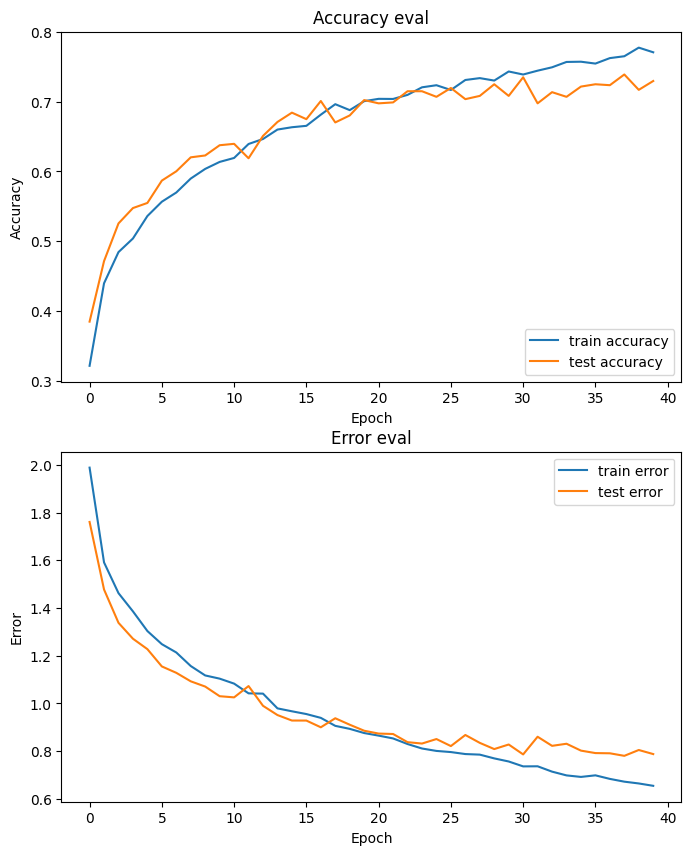

In [68]:
model.compile(optimizer=adam,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 epochs = 40,
                 batch_size = 32)

clear_output()

plot_history(hist)

As we can see the accuracy has improved by Significant amount

In [69]:
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test accuracy: {test_accuracy}")

def predict(model, X, y):
    X = X[np.newaxis,...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print(f"Expected index: {y}, Predicted index: {predicted_index}")
predict(model, X_test[10], y_test[10])

79/79 [==============================] - 1s 16ms/step - loss: 0.7634 - accuracy: 0.7381
Test accuracy: 0.7380856871604919
1/1 [==============================] - 0s 309ms/step
Expected index: 7, Predicted index: [7]
